In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from Networks import *

In [9]:
from Utility import *

In [10]:
from matplotlib import pyplot as plt

In [11]:
dataFolder = r'F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Data'
numMarkers = 50
markerSelected = 49

numTest = 200

In [12]:
imgsPerMaker = []
uvsPerMaker = []

for iM in range(numMarkers):
    outImgDataFile = join(dataFolder, 'ImgMarker_' + str(iM).zfill(3) + '.npy')
    outUVDataFile = join(dataFolder, 'UVMarker_' + str(iM).zfill(3) + '.npy')

    img = np.load(outImgDataFile)
    uv = np.load(outUVDataFile)
    
    imgsPerMaker.append(img)
    uvsPerMaker.append(uv)

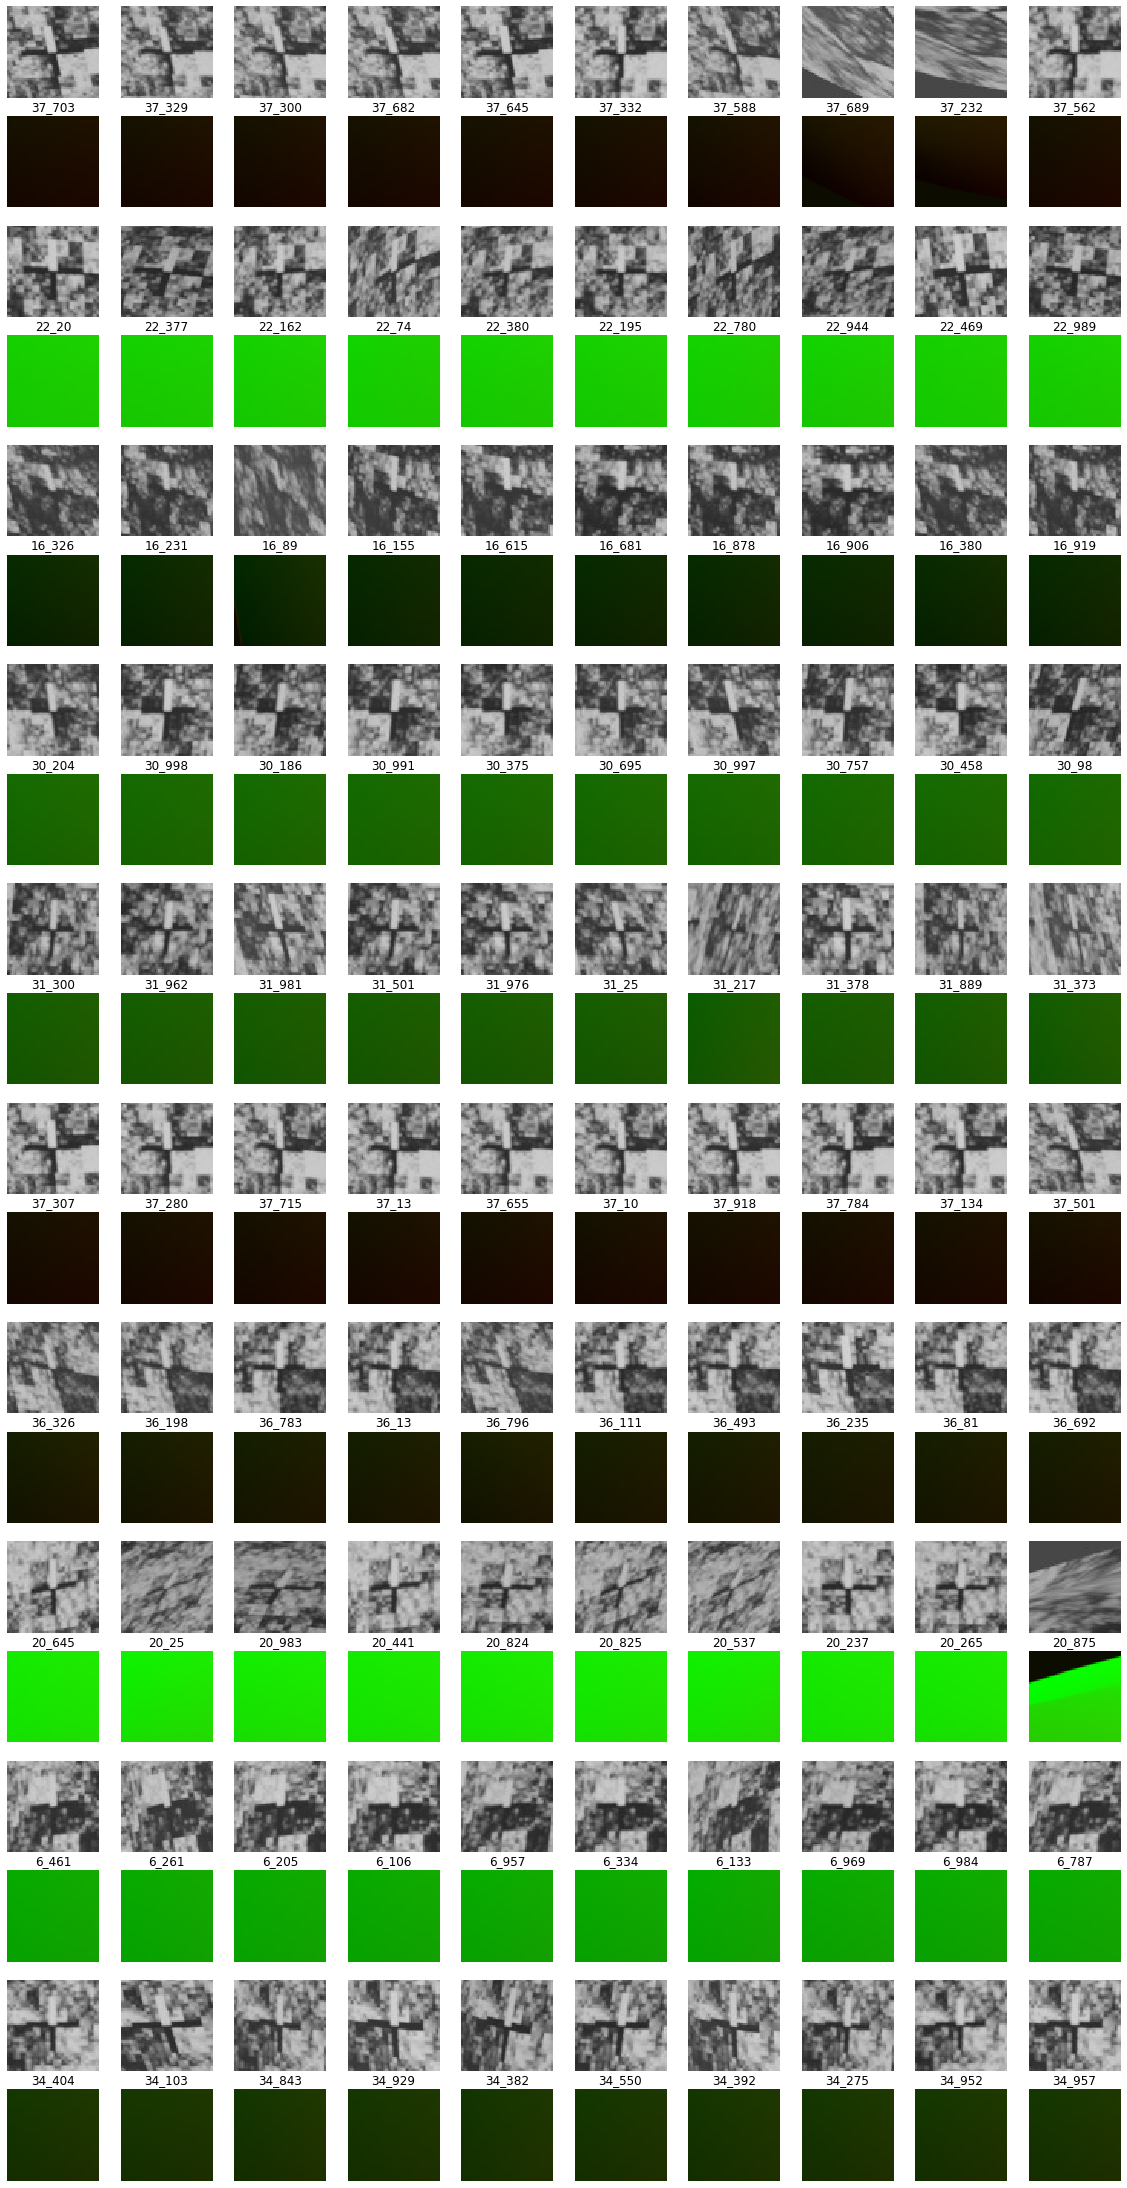

In [13]:
gridH = 20
gridW = 10
fig, axs = plt.subplots(gridH, gridW)


fig.set_size_inches(20, 20*(gridH/gridW))
for i, iMarker in enumerate(range(int(gridH/2))):
    marker = np.random.randint(0, len(imgsPerMaker))
    imgIds = np.random.randint(0, len(imgsPerMaker[marker]), size=(gridW,))
    for j, iImg in enumerate(imgIds):
        axs[i*2, j].imshow(imgsPerMaker[marker][iImg, ...], cmap="gray")
        axs[i*2, j].axis('off')
    
        axs[i*2+1, j].imshow(predToRGB(uvsPerMaker[marker][iImg, ...]), )
        axs[i*2+1, j].set_title("%d_%d" % (marker, iImg))
        axs[i*2+1, j].axis('off')
    
    
    

In [17]:
# uvExtractor = UVExtractor('resnet_101', training=False,  pre_trained_model=r'C:\Code\MyRepo\00_DeepLearning\DeepLab-V3\data\models\pretrained\resnet_101\resnet_v2_101.ckpt')
uvExtractor = UVExtractor('resnet_50', training=True,)

In [15]:
fd = {uvExtractor.inputs:imgsPerMaker[0][:10, :,:,:],
      uvExtractor.is_training:False,
      uvExtractor.target_width:60,
      uvExtractor.target_height:60,
      uvExtractor.labels:uvsPerMaker[0][:10, ...]
     }
featureMap = uvExtractor.sess.run(uvExtractor.outputs, feed_dict=fd)
print(featureMap.shape)

(10, 15, 15, 2)


In [17]:
np.max(uv[..., 0]) - np.min(uv[..., 0])

0.24454748630523682

In [18]:
numData = imgsPerMaker[markerSelected].shape[0]
sizeTrain = numData - numTest

trainData = imgsPerMaker[markerSelected][:-numTest, ...]
trainUV = uvsPerMaker[markerSelected][:-numTest, ...]

testData = imgsPerMaker[markerSelected][-numTest:, ...]
testUV = uvsPerMaker[markerSelected][-numTest:, ...]



In [26]:
numEpoch = 51
batchSize = 10
weight_decay = 5e-4
lr = 1e-5

In [27]:
numBatch = int(np.ceil(sizeTrain / batchSize))

for iEpoch in range(numEpoch):
    for iBatch in range(numBatch):
        fd = {uvExtractor.inputs:trainData[iBatch*batchSize:(iBatch+1)*batchSize, :,:,:],
              uvExtractor.is_training:True,
              uvExtractor.target_width:60,
              uvExtractor.target_height:60,
              uvExtractor.labels:trainUV[iBatch*batchSize:(iBatch+1)*batchSize, ...],
              uvExtractor.weight_decay: weight_decay,
              uvExtractor.learning_rate: lr
             }
        _, train_loss,  = uvExtractor.sess.run([uvExtractor.optimizer,  uvExtractor.loss,], feed_dict=fd)
    fdVal = {uvExtractor.inputs:testData[:batchSize, ...],
              uvExtractor.is_training:True,
              uvExtractor.target_width:60,
              uvExtractor.target_height:60,
              uvExtractor.labels:testUV[:batchSize, ...],
              uvExtractor.weight_decay: weight_decay,
              uvExtractor.learning_rate: lr
             }
    trainOutputs = uvExtractor.sess.run([ uvExtractor.outputs_resized,], feed_dict=fd)
    outputs, valLoss =  uvExtractor.sess.run([uvExtractor.outputs_resized, uvExtractor.loss,], feed_dict=fdVal)
    print("train_loss", train_loss, "max validation err:", np.max(np.abs(trainOutputs-fd[uvExtractor.labels])))
    print("mean validation loss", valLoss, "max validation err:", np.max(np.abs(outputs-testUV[:batchSize, ...])))
    
    

train_loss 0.055815388 max validation err: 2.110469251871109
mean validation loss 0.08230642 max validation err: 2.3524332270026207
train_loss 0.033981305 max validation err: 1.7413912117481232
mean validation loss 0.070647486 max validation err: 2.1896875128149986
train_loss 0.023367202 max validation err: 1.548617273569107
mean validation loss 0.06313741 max validation err: 2.042652629315853
train_loss 0.018474145 max validation err: 1.4679019749164581
mean validation loss 0.057835985 max validation err: 1.9381065368652344
train_loss 0.016410781 max validation err: 1.259930819272995
mean validation loss 0.055480108 max validation err: 1.9434911236166954
train_loss 0.023879234 max validation err: 1.055904969573021
mean validation loss 0.055146433 max validation err: 1.8418460115790367
train_loss 0.04304987 max validation err: 1.31721793115139
mean validation loss 0.095515616 max validation err: 2.1607608944177628
train_loss 0.034789145 max validation err: 0.9575469046831131
mean valid

KeyboardInterrupt: 

In [ ]:
saver = tf.train.Saver()
save_path = saver.save(uvExtractor.sess, r"C:\Code\MyRepo\03_capture\DenseLocalizationTexture\S03_NetworksTraining\Save\N02_UVExtractor_DeepLabStructure_SingleMarker_epoch_"+str(iEpoch).zfill(6)+".ckpt")
print("Model saved in path: %s" % save_path)

In [ ]:
fdVal = {uvExtractor.inputs:trainData[100:101, ...],
              uvExtractor.is_training:True,
              uvExtractor.target_width:60,
              uvExtractor.target_height:60,
              uvExtractor.labels:trainUV[:1, ...],
              uvExtractor.weight_decay: weight_decay,
              uvExtractor.learning_rate: lr
             }
outputs = uvExtractor.sess.run(uvExtractor.outputs_resized, feed_dict=fdVal)

In [ ]:
pred = np.stack([outputs[..., 0], outputs[..., 1], np.zeros(outputs[..., 1].shape)], -1)

In [ ]:
plt.imshow(pred[0,...])

In [ ]:
plt.imshow(predToRGB(trainUV[100,...]))

In [ ]:
np.mean(np.abs(outputs[0,...] - trainUV[0,...]))

In [ ]:
figs, axs = plt.subplots(10, 4)

for iIm in range(10):
    for iFig in range(4):
        fdVal = {uvExtractor.inputs:trainData[100:101, ...],
              uvExtractor.is_training:True,
              uvExtractor.target_width:60,
              uvExtractor.target_height:60,
              uvExtractor.labels:trainUV[:1, ...],
              uvExtractor.weight_decay: weight_decay,
              uvExtractor.learning_rate: lr
             }
        outputs = uvExtractor.sess.run(uvExtractor.outputs_resized, feed_dict=fdVal)
